# Exposures class

Exposure can describe the geographical distribution of people, livelihoods and assets or infrastructure; all items potentially exposed to hazards. It is represented in the class `Exposures`, which is a [GeoDataFrame](https://geopandas.readthedocs.io/en/latest/data_structures.html#geodataframe) of Python's library [geopandas](https://geopandas.readthedocs.io/en/latest/gallery/cartopy_convert.html).

The variables (columns) and metada contained are:

 - tag (Tag): metada - information about the source data
 - ref_year (int): metada - reference year
 - value_unit (str): metada - unit of the exposures values
 - **latitude** (pd.Series): latitude
 - **longitude** (pd.Series): longitude
 - **value** (pd.Series): a value for each exposure
 - if_ (pd.Series, optional): e.g. if_TC. impact functions ids for hazard TC. There might be different hazards defined: if_TC, if_FL, ... If not provided, set to default `if_` with ids 1 in check().
 - geometry (pd.Series, optional): geometry of type Point of each instance. Computed in method `set_geometry_points()`
 - meta (dict): dictionary containing corresponding raster properties (if any): width, height, crs and transform must be present at least (transform needs to contain upper left corner!). Exposures might not contain all the points of the corresponding raster.
 - deductible (pd.Series, optional): deductible value for each exposure. Used for insurance
 - cover (pd.Series, optional): cover value for each exposure. Used for insurance
 - category_id (pd.Series, optional): category id (e.g. building code) for each exposure
 - region_id (pd.Series, optional): region id (e.g. country ISO code) for each exposure
 - centr_* (pd.Series, optional): e.g. centr_TC. centroids index for hazard TC. There might be different hazards defined: centr_TC, centr_FL, ... Computed in method `assign_centroids()`

Some of the variables are *optional*. This means that the package `climada.engine` also works without these variables set. For instance, the `region_id` and `category_id` values only provide additional information, whilst the `centr_*` variable can be computed if not provided using the method `assign_centroids()`. The attibute `geometry` is only needed to execute the methods of `geopandas` and can be set using the method `set_geometry_points()`. 

`if_` is the most important attribute, since it relates the exposures to the hazard by specifying the impact functions. Ideally it should be set to the specific hazard (e.g. `if_TC`) so that different hazards can be set in the same Exposures (e.g. `if_TC` and `if_FL`). If there isn't any `if_*` value provided, the `check()` method puts a default `if_` with ones which can be used by the impact calculation in `engine`.

After defining an `Exposures` instance use always the `check()` method to see which attributes are missing. This method will raise an ERROR if `value`, `longitude` or `latitude` ar missing and an INFO messages for the the optional variables not set.

## Define Exposures from a DataFrame

In [1]:
import numpy as np
from pandas import DataFrame
from climada.entity import Exposures

# Fill DataFrame
exp_df = DataFrame()
n_exp = 100*100
exp_df['value'] = np.arange(n_exp) # provide value
lat, lon = np.mgrid[15 : 35 : complex(0, np.sqrt(n_exp)), 20 : 40 : complex(0, np.sqrt(n_exp))]
exp_df['latitude'] = lat.flatten() # provide latitude
exp_df['longitude'] = lon.flatten() # provide longitude
exp_df['if_TC'] = np.ones(n_exp, int) # provide impact functions for TC or any other peril

print('\x1b[1;03;30;30m' + 'exp_df is a DataFrame:', str(type(exp_df)) + '\x1b[0m')
print('\x1b[1;03;30;30m' + 'exp_df looks like:' + '\x1b[0m')
print(exp_df.head())

# Generate Exposures
exp_df = Exposures(exp_df)
print('\n' + '\x1b[1;03;30;30m' + 'exp_df is now an Exposures:', str(type(exp_df)) + '\x1b[0m')
exp_df.set_geometry_points() # set geometry attribute (shapely Points) from GeoDataFrame from latitude and longitude
print('\n' + '\x1b[1;03;30;30m' + 'check method logs:' + '\x1b[0m')
exp_df.check() # puts metadata that has not been assigned

print('\n' + '\x1b[1;03;30;30m'  + 'exp_df looks like:' + '\x1b[0m')
print(exp_df.head())

2020-03-13 16:27:06,555 - climada - DEBUG - Loading default config file: /Users/aznarsig/Documents/Python/climada_python/climada/conf/defaults.conf
exp_df is a DataFrame: <class 'pandas.core.frame.DataFrame'>
exp_df looks like:
   value  latitude  longitude  if_TC
0      0      15.0  20.000000      1
1      1      15.0  20.202020      1
2      2      15.0  20.404040      1
3      3      15.0  20.606061      1
4      4      15.0  20.808081      1

exp_df is now an Exposures: <class 'climada.entity.exposures.base.Exposures'>
2020-03-13 16:27:08,988 - climada.util.coordinates - INFO - Setting geometry points.

check method logs:
2020-03-13 16:27:09,546 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-03-13 16:27:09,547 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-03-13 16:27:09,548 - climada.entity.exposures.base - INFO - ref_year metadata set to default value: 2018
202

## Define Exposures from a GeoDataFrame with POINT geometry

In [2]:
import numpy as np
import geopandas as gpd
from climada.entity import Exposures

# Fill GeoDataFrame
world = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
print('\x1b[1;03;30;30m' + 'World is a GeoDataFrame:', str(type(world)) + '\x1b[0m')
print('\x1b[1;03;30;30m' + 'World looks like:' + '\x1b[0m')
print(world.head())

# Generate Exposures
exp_gpd = Exposures(world)
print('\n' + '\x1b[1;03;30;30m' + 'exp_gpd is now an Exposures:', str(type(exp_gpd)) + '\x1b[0m')
exp_gpd['value'] = np.arange(world.shape[0]) # provide value
exp_gpd.set_lat_lon() # set latitude and longitude attributes from geometry
exp_gpd['if_TC'] = np.ones(world.shape[0], int) # provide impact functions for TC or any other peril

print('\n' + '\x1b[1;03;30;30m' + 'check method logs:' + '\x1b[0m')
exp_gpd.check() # puts metadata that has not been assigned

print('\n' + '\x1b[1;03;30;30m'  + 'exp_gpd looks like:' + '\x1b[0m')
print(exp_gpd.head())

World is a GeoDataFrame: <class 'geopandas.geodataframe.GeoDataFrame'>
World looks like:
           name                                     geometry
0  Vatican City  POINT (12.45338654497177 41.90328217996012)
1    San Marino    POINT (12.44177015780014 43.936095834768)
2         Vaduz  POINT (9.516669472907267 47.13372377429357)
3    Luxembourg  POINT (6.130002806227083 49.61166037912108)
4       Palikir  POINT (158.1499743237623 6.916643696007725)

exp_gpd is now an Exposures: <class 'climada.entity.exposures.base.Exposures'>
2020-03-13 16:27:09,599 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.

check method logs:
2020-03-13 16:27:09,612 - climada.entity.exposures.base - INFO - crs set to default value: {'init': 'epsg:4326', 'no_defs': True}
2020-03-13 16:27:09,613 - climada.entity.exposures.base - INFO - tag metadata set to default value:  File: 
 Description: 
2020-03-13 16:27:09,614 - climada.entity.exposures.base - INFO - ref_year metadata s

## Read Exposures of an excel file

Excel files can be ingested directly following the template provided in `climada_python/data/system/entity_template.xlsx`, in the sheet `assets`.

In [3]:
# An excel file with the variables defined in the template can be directly ingested using these commands
import pandas as pd
from climada.util.constants import ENT_TEMPLATE_XLS
from climada.entity import Exposures

# Fill DataFrame from Excel file
file_name = ENT_TEMPLATE_XLS # provide absolute path of the excel file
exp_templ = pd.read_excel(file_name)

print('\x1b[1;03;30;30m' + 'exp_templ is a DataFrame:', str(type(exp_templ)) + '\x1b[0m')
print('\x1b[1;03;30;30m' + 'exp_templ looks like:' + '\x1b[0m')
print(exp_templ.head())

# Generate Exposures
exp_templ = Exposures(exp_templ)
print('\n' + '\x1b[1;03;30;30m' + 'exp_templ is now an Exposures:', str(type(exp_templ)) + '\x1b[0m')
exp_templ.set_geometry_points() # set geometry attribute (shapely Points) from GeoDataFrame from latitude and longitude
print('\n' + '\x1b[1;03;30;30m' + 'check method logs:' + '\x1b[0m')
exp_templ.check() # puts metadata that has not been assigned

print('\n' + '\x1b[1;03;30;30m'  + 'exp_templ looks like:' + '\x1b[0m')
print(exp_templ.head())

exp_templ is a DataFrame: <class 'pandas.core.frame.DataFrame'>
exp_templ looks like:
    latitude  longitude         value  deductible         cover  region_id  \
0  26.933899 -80.128799  1.392750e+10           0  1.392750e+10          1   
1  26.957203 -80.098284  1.259606e+10           0  1.259606e+10          1   
2  26.783846 -80.748947  1.259606e+10           0  1.259606e+10          1   
3  26.645524 -80.550704  1.259606e+10           0  1.259606e+10          1   
4  26.897796 -80.596929  1.259606e+10           0  1.259606e+10          1   

   category_id  if_TC  centr_TC  if_FL  centr_FL  
0            1      1         1      1         1  
1            1      1         2      1         2  
2            1      1         3      1         3  
3            1      1         4      1         4  
4            1      1         5      1         5  

exp_templ is now an Exposures: <class 'climada.entity.exposures.base.Exposures'>
2020-03-13 16:27:09,737 - climada.util.coordinates - INFO

## Read Exposures of any file type supported by GeoDataFrame and DataFrame

Geopandas can read almost any vector-based spatial data format including ESRI shapefile, GeoJSON files and more, see [readers geopandas](http://geopandas.org/io.html). Pandas supports formats such as csv, html or sql; see [readers pandas](https://pandas.pydata.org/pandas-docs/stable/io.html). Using the corresponding readers, `DataFrame` and `GeoDataFrame` can be filled and provided to `Exposures` following the previous examples.

## Read Exposures from a raster file

Raster data contained in files of any format supported by [rasterio](https://rasterio.readthedocs.io/en/stable/) can be charged using `set_from_raster()`. The attribute `meta` containing the raster properties is then set.

In [4]:
# dummy example
from rasterio.windows import Window
from climada.util.constants import HAZ_DEMO_FL
exp = Exposures()
exp.set_from_raster(HAZ_DEMO_FL, window= Window(10, 20, 50, 60)) # check all the options (e.g. change CRS)
exp.check()
print('Meta:', exp.meta)

2020-03-13 16:27:09,766 - climada.util.coordinates - INFO - Reading /Users/aznarsig/Documents/Python/climada_python/data/demo/SC22000_VE__M1.grd.gz
2020-03-13 16:27:09,815 - climada.entity.exposures.base - INFO - ref_year metadata set to default value: 2018
2020-03-13 16:27:09,816 - climada.entity.exposures.base - INFO - value_unit metadata set to default value: USD
2020-03-13 16:27:09,817 - climada.entity.exposures.base - INFO - Setting if_ to default impact functions ids 1.
2020-03-13 16:27:09,818 - climada.entity.exposures.base - INFO - centr_ not set.
2020-03-13 16:27:09,819 - climada.entity.exposures.base - INFO - deductible not set.
2020-03-13 16:27:09,820 - climada.entity.exposures.base - INFO - cover not set.
2020-03-13 16:27:09,821 - climada.entity.exposures.base - INFO - category_id not set.
2020-03-13 16:27:09,823 - climada.entity.exposures.base - INFO - region_id not set.
2020-03-13 16:27:09,824 - climada.entity.exposures.base - INFO - geometry not set.
Meta: {'driver': 'GS

## Read exposures generated by CLIMADA

The methods `read_mat()` will read `Exposures` generated by CLIMADA's MATLAB version and `read_hdf5()` will read the ones generated CLIMADA in Python. These methods will allow to read all the metadata in addition to the `GeoDataFrame`.

## Methods 

In [5]:
# read MATLAB file from climada MATLAB version with read_mat() 
# and the ones generated with the Python version with read_hdf5()
from climada.util.constants import EXP_DEMO_H5

exp_hdf5 = Exposures()
exp_hdf5.read_hdf5(EXP_DEMO_H5)
exp_hdf5.check()
print(type(exp_hdf5))

2020-03-13 16:27:09,835 - climada.entity.exposures.base - INFO - Reading /Users/aznarsig/Documents/Python/climada_python/data/demo/exp_demo_today.h5
2020-03-13 16:27:09,947 - climada.entity.exposures.base - INFO - meta metadata set to default value: None
2020-03-13 16:27:09,948 - climada.entity.exposures.base - INFO - centr_ not set.
<class 'climada.entity.exposures.base.Exposures'>


In [6]:
# add sea points
from climada.entity import add_sea
exp_templ_sea = add_sea(exp_templ, (10, 5)) # 10km from coast and at 5km resolution
exp_templ_sea.check()
exp_templ_sea.tail() # region_id set to -1 for the sea points

2020-03-13 16:27:09,957 - climada.entity.exposures.base - INFO - Adding sea at 5 km resolution and 10 km distance from coast.
2020-03-13 16:27:10,390 - climada.util.coordinates - INFO - Setting geometry points.


,latitude,longitude,value,deductible,cover,region_id,category_id,if_TC,centr_TC,if_FL,centr_FL,geometry
58,27.005495,-79.939012,0.0,0,0.0,-1,0,0,0,0,0,POINT (-79.93901179481654 27.00549520230383)
59,27.050492,-80.074001,0.0,0,0.0,-1,0,0,0,0,0,POINT (-80.07400099568045 27.05049160259181)
60,27.050492,-80.029005,0.0,0,0.0,-1,0,0,0,0,0,POINT (-80.02900459539248 27.05049160259181)
61,27.050492,-79.984008,0.0,0,0.0,-1,0,0,0,0,0,POINT (-79.98400819510451 27.05049160259181)
62,27.050492,-79.939012,0.0,0,0.0,-1,0,0,0,0,0,POINT (-79.93901179481654 27.05049160259181)


### all the methods from GeoDataFrame

Have a look into all the possible methods provided by `GeoDataFrame`. They will allow you to perform operations like the following:

In [7]:
# extract data in a region: latitudes between -5 and 5
sel_exp = exp_gpd.cx[:, -5:5]
sel_exp # the output is of type GeoDataFrame

,name,geometry,value,latitude,longitude,if_TC
9,Tarawa,POINT (173.0175708285494 1.338187505624603),9,1.338188,173.017571,1
13,Kigali,POINT (30.05858591906411 -1.95164421006325),13,-1.951644,30.058586,1
15,Juba,POINT (31.58002559278731 4.829975198277964),15,4.829975,31.580026,1
27,Bujumbura,POINT (29.3600060615284 -3.376087220374643),27,-3.376087,29.360006,1
48,Kampala,POINT (32.58137766712105 0.318604813383331),48,0.318605,32.581378,1
65,Mogadishu,POINT (45.36473175245874 2.068627192947531),65,2.068627,45.364732,1
79,Quito,POINT (-78.5019969671124 -0.2130423220355624),79,-0.213042,-78.501997,1
84,Malabo,POINT (8.783277545821136 3.750015278026183),84,3.750015,8.783278,1
90,Libreville,POINT (9.457965045823698 0.3853886097185182),90,0.385389,9.457965,1
98,Brazzaville,POINT (15.28274363384867 -4.257239913197509),98,-4.257240,15.282744,1


In [8]:
# extract data in a polygon
from shapely.geometry import Polygon

poly = Polygon([(0, -10), (0, 10), (10, 5)])
sel_exp = exp_gpd[exp_gpd.intersects(poly)]
sel_exp # the output is of type Exposures

,name,geometry,value,latitude,longitude,if_TC
36,Lome,POINT (1.22081126074562 6.133882930268385),36,6.133883,1.220811,1
84,Malabo,POINT (8.783277545821136 3.750015278026183),84,3.750015,8.783278,1
113,Cotonou,POINT (2.518044740568598 6.401954422782467),113,6.401954,2.518045,1
125,Sao Tome,POINT (6.733325153234773 0.3334021188329075),125,0.333402,6.733325,1


In [9]:
# change reference system
sel_exp.to_crs(epsg=3395, inplace=True) # use help to see more options: help(sel_exp.to_crs)
sel_exp.crs

{'init': 'epsg:3395', 'no_defs': True}

In [10]:
# concatenate exposures
import pandas as pd

exp_all = pd.concat([exp_templ, exp_df], ignore_index=True, sort=False)

# the output is of type Exposures
print('exp_all type and number of rows:', type(exp_all), exp_all.shape[0])

# NaNs will appear in the missing values
exp_all.tail()

exp_all type and number of rows: <class 'climada.entity.exposures.base.Exposures'> 10024


,latitude,longitude,value,deductible,cover,region_id,category_id,if_TC,centr_TC,if_FL,centr_FL,geometry
10019,35.0,39.191919,9995.0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,POINT (39.19191919191919 35)
10020,35.0,39.393939,9996.0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,POINT (39.39393939393939 35)
10021,35.0,39.595960,9997.0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,POINT (39.5959595959596 35)
10022,35.0,39.797980,9998.0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,POINT (39.7979797979798 35)
10023,35.0,40.000000,9999.0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,POINT (40 35)


In [11]:
# remove values
exp_all_1 = exp_all.drop([1]) # delete row 1
print('\x1b[1;03;30;30m' + 'Row 1 deleted:' + '\x1b[0m')
print(exp_all_1.head())
exp_all_val = exp_all.drop(['value'], axis=1) # delete colomn 'value'
print('\x1b[1;03;30;30m' + 'Column value deleted:' + '\x1b[0m')
print(exp_all_val.head())

Row 1 deleted:
    latitude  longitude         value  deductible         cover  region_id  \
0  26.933899 -80.128799  1.392750e+10         0.0  1.392750e+10        1.0   
2  26.783846 -80.748947  1.259606e+10         0.0  1.259606e+10        1.0   
3  26.645524 -80.550704  1.259606e+10         0.0  1.259606e+10        1.0   
4  26.897796 -80.596929  1.259606e+10         0.0  1.259606e+10        1.0   
5  26.925359 -80.220966  1.259606e+10         0.0  1.259606e+10        1.0   

   category_id  if_TC  centr_TC  if_FL  centr_FL                      geometry  
0          1.0      1       1.0    1.0       1.0  POINT (-80.128799 26.933899)  
2          1.0      1       3.0    1.0       3.0  POINT (-80.748947 26.783846)  
3          1.0      1       4.0    1.0       4.0  POINT (-80.550704 26.645524)  
4          1.0      1       5.0    1.0       5.0  POINT (-80.596929 26.897796)  
5          1.0      1       6.0    1.0       6.0  POINT (-80.220966 26.925359)  
Column value deleted:
    lati

## Visualize Exposures

The method `plot_hexbin()` uses `cartopy`  and `matplotlib`'s `hexbin` function to represent the exposures values as 2d bins over a map. Configure your plot by fixing the different inputs of the method or by modifying the returned `matplotlib` figure and axes.

Plotting exp_df.


/Users/aznarsig/Documents/Python/climada_python/climada/util/plot.py:311: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


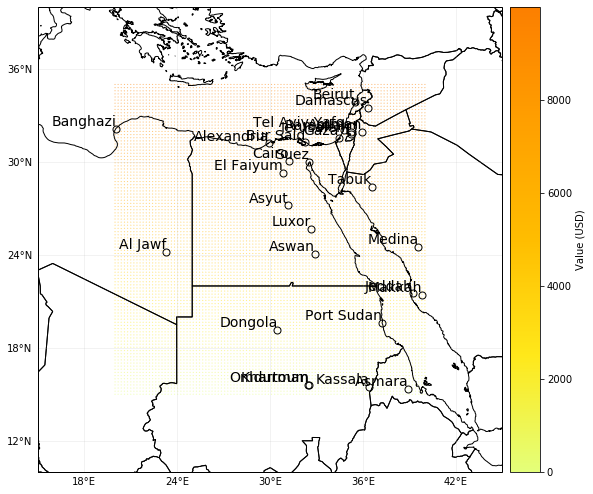

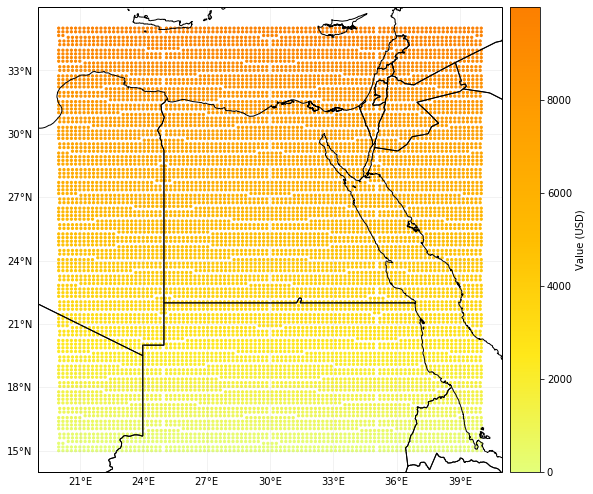

In [12]:
# execute 'Define Exposures from a DataFrame' to see the results
print('\x1b[1;03;30;30m' + 'Plotting exp_df.' + '\x1b[0m')
axs = exp_df.plot_hexbin()
axs.set_xlim(15, 45) # modify x-axis borders
axs.set_ylim(10, 40) # modify y-axis borders

# use buffer option to enlarge borders of plot
# use gridsize to change bins size
exp_df.plot_hexbin(pop_name=False, buffer=1.0, gridsize=200)

Plotting exp_gpd.
2020-03-13 16:27:17,828 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


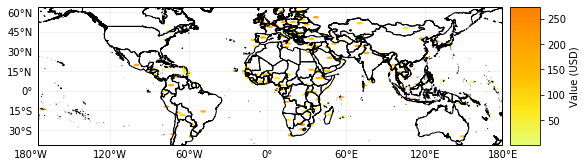

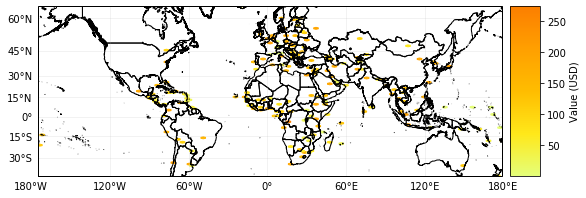

In [13]:
# execute 'Define Exposures from a GeoDataFrame with POINT geometry' to see the results
print('\x1b[1;03;30;30m' + 'Plotting exp_gpd.' + '\x1b[0m')
exp_gpd.plot_hexbin(pop_name=False)

# when the geometry is changed, the plot is adapted correspondingly
exp_gpd.to_crs({'init':'epsg:3395'}, inplace=True)
exp_gpd.plot_hexbin(pop_name=False)

The method `plot_scatter()` uses `cartopy` and `matplotlib`'s `scatter` function to represent the points values over a 2d map. As usal, it returns the figure and axes, which can be modify aftwerwards.

2020-03-13 16:27:31,559 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


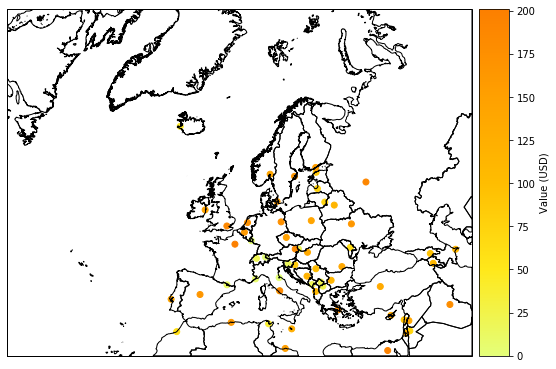

In [14]:
exp_gpd.to_crs({'init':'epsg:3035'}, inplace=True)
exp_gpd.plot_scatter(pop_name=False)

The method `plot_raster()` rasterizes the points into the given resolution. Use the `save_tiff` option to save the resulting `tiff` file.

2020-03-13 16:27:37,088 - climada.util.coordinates - INFO - Raster from resolution 0.20202020202019355 to 0.20202020202019355.
2020-03-13 16:27:39,086 - climada.util.coordinates - INFO - Raster from resolution 0.20202020202019355 to 0.5.


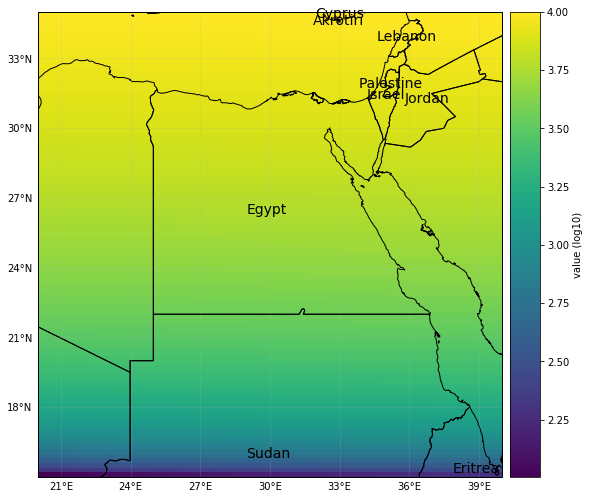

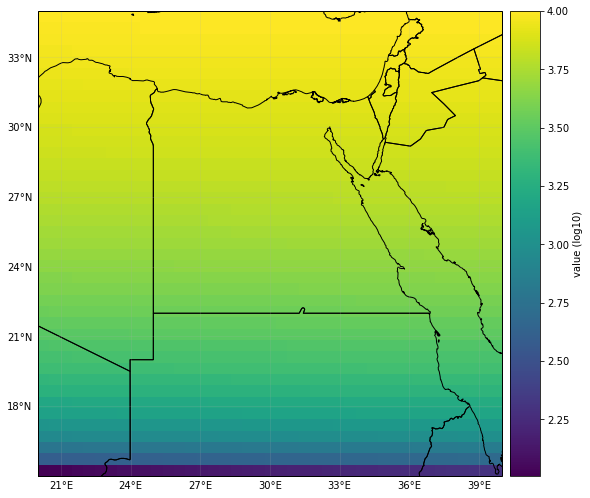

In [15]:
from climada.util.plot import add_cntry_names # use climada's plotting utilities
ax = exp_df.plot_raster() # plot with same resolution as data
add_cntry_names(ax, [exp_df.longitude.min(), exp_df.longitude.max(), exp_df.latitude.min(), exp_df.latitude.max()])

# use plot_raster(save_tiff) to save the corresponding raster in tiff format
# change raster resolution
ax = exp_df.plot_raster(raster_res=0.5, save_tiff='results/exp_df.tiff') 

Finally, the method `plot_basemap()` plots the scatter points over a satellite image using [contextily](https://github.com/darribas/contextily) library:

2020-03-13 16:27:41,624 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/aznarsig/anaconda3/envs/climada_env/lib/python3.7/site-packages/contextily/tile.py:199: FutureWarning: The url format using 'tileX', 'tileY', 'tileZ' as placeholders is deprecated. Please use '{x}', '{y}', '{z}' instead.
  FutureWarning,


2020-03-13 16:27:43,082 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2020-03-13 16:27:43,089 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2020-03-13 16:27:44,200 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


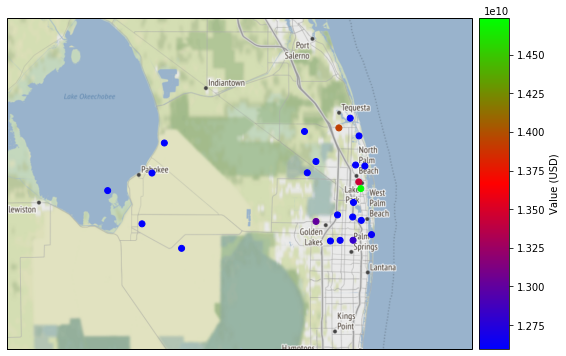

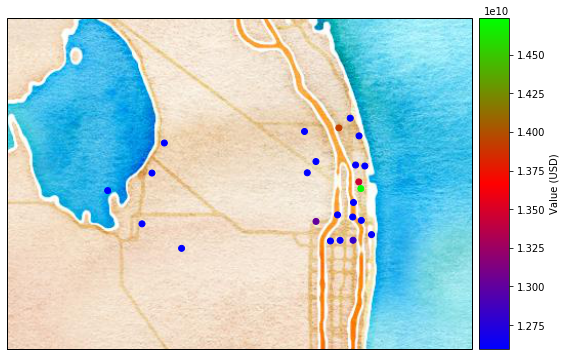

In [16]:
import contextily as ctx
# select the background image from the available ctx.sources
ax = exp_templ.plot_basemap(buffer=30000, cmap='brg') # using open street map
ax = exp_templ.plot_basemap(buffer=30000, url=ctx.sources.ST_WATERCOLOR, cmap='brg', zoom=9) # set image zoom

Since `Exposures` is a `GeoDataFrame`, any function for visualization from geopandas can be used. Check [making maps](https://geopandas.readthedocs.io/en/latest/mapping.html#) and [examples gallery](http://geopandas.org/gallery/index.html).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2eb21128>]],
      dtype=object)

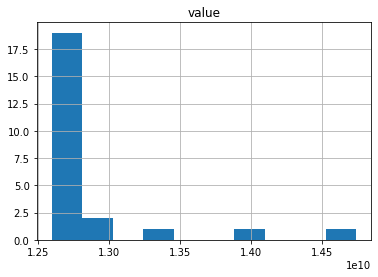

In [17]:
# other visualization types
exp_templ.hist(column='value')

## Write Exposures

Exposures can be saved in any format available for `GeoDataFrame` (see fiona.supported_drivers) and `DataFrame` ([pandas IO tools]('https://pandas.pydata.org/pandas-docs/stable/io.html')). Take into account that in many of these formats the metadata (e.g. variables `ref_year`, `value_unit` and `tag`) will not be saved. Use instead the format hdf5 provided by `Exposures` methods `write_hdf5()` and `read_hdf5()` to handle all the data.

In [18]:
# GeoDataFrame formats
import fiona; fiona.supported_drivers

# GeoDataFrame default: ESRI shape file in current path. metadata not saved!
exp_templ.to_file('results/exp_templ')

# DataFrame save to csv format. geometry writen as string, metadata not saved!
exp_templ.to_csv('results/exp_templ_csv', sep='\t')

In [19]:
# write
exp_templ.write_hdf5('results/exp_temp.h5')
# read
exp_read = Exposures()
exp_read.read_hdf5('results/exp_temp.h5')
exp_read.head()

2020-03-13 16:27:44,859 - climada.entity.exposures.base - INFO - Writting results/exp_temp.h5
2020-03-13 16:27:44,881 - climada.entity.exposures.base - INFO - Reading results/exp_temp.h5


/Users/aznarsig/anaconda3/envs/climada_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['geometry']]

  exec(code_obj, self.user_global_ns, self.user_ns)


,latitude,longitude,value,deductible,cover,region_id,category_id,if_TC,centr_TC,if_FL,centr_FL,geometry
0,26.933899,-80.128799,1.392750e+10,0,1.392750e+10,1,1,1,1,1,1,POINT (-80.12879899999999 26.93389899999996)
1,26.957203,-80.098284,1.259606e+10,0,1.259606e+10,1,1,1,2,1,2,POINT (-80.09828400000001 26.957203)
2,26.783846,-80.748947,1.259606e+10,0,1.259606e+10,1,1,1,3,1,3,POINT (-80.748947 26.783846)
3,26.645524,-80.550704,1.259606e+10,0,1.259606e+10,1,1,1,4,1,4,POINT (-80.550704 26.645524)
4,26.897796,-80.596929,1.259606e+10,0,1.259606e+10,1,1,1,5,1,5,POINT (-80.596929 26.89779599999996)


Finallly, as with any Python object, use climada's save option to save it in pickle format.

In [20]:
# save in pickle format
from climada.util.save import save
# this generates a results folder in the current path and stores the output there
save('exp_templ.pkl.p', exp_templ) # creates results folder and stores there

2020-03-13 16:27:44,911 - climada.util.save - INFO - Written file /Users/aznarsig/Documents/Python/climada_python/doc/tutorial/results/exp_templ.pkl.p


## Dask - improving performance for big exposure

Dask is used in some methods of CLIMADA and can be activated easily by proving the scheduler.

In [21]:
# set_geometry_points is expensive for big exposures
# for small amount of data, the execution time might be even greater when using dask
exp_df.drop(columns=['geometry'], inplace=True)
print(exp_df.head())
exp_df.set_geometry_points(scheduler='processes')
print(exp_df.head())

   value  latitude  longitude  if_TC
0      0      15.0  20.000000      1
1      1      15.0  20.202020      1
2      2      15.0  20.404040      1
3      3      15.0  20.606061      1
4      4      15.0  20.808081      1
2020-03-13 16:27:44,921 - climada.util.coordinates - INFO - Setting geometry points.
   value  latitude  longitude  if_TC                      geometry
0      0      15.0  20.000000      1                 POINT (20 15)
1      1      15.0  20.202020      1   POINT (20.2020202020202 15)
2      2      15.0  20.404040      1   POINT (20.4040404040404 15)
3      3      15.0  20.606061      1  POINT (20.60606060606061 15)
4      4      15.0  20.808081      1  POINT (20.80808080808081 15)
